## Classification with Python

Hopefully now you are feeling a bit more comfortable with Python, Kaggle, and modeling. 

The next kaggle project:

https://www.kaggle.com/c/costa-rican-household-poverty-prediction

### Grading

This homework is due **March 14, 2019 by 4:00 pm Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model evaluation: Did you evaluate your model on multiple metrics? Where does your model do well? Where could it be improved? How are the metrics different?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

### The essentials
Working through this problem I went through a variety of models and attempted several different approaches. So that is why there is so many imports here. I do not accurately remember which ones I am using in the code, so I have just decided to leave them all here. 

In [241]:
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression
%matplotlib inline
import statsmodels.formula.api as smf
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from collections import OrderedDict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

# Overview
In this notebook we will be attempting Kaggle's "Costa Rican Household Poverty Level Prediction" project. The basis of this project is that we are trying to categorize individuals into 1 of 4 different levels poverty/risk of poverty. "Extreme poverty, moderate poverty, vunerable and non-vunerable". We have housing data along with several other variables such as years of education and other weird things such as if they own a tablet or not. The purpose of making this model is then turning around and using this model in order to assign social programs. So the accuracy of a model such as this is of the up most importance.

# Import and Initial Analysis

Let us begin by loading the data up!

In [312]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_cols = train.columns
test_cols = test.columns
y = train.loc[(train['parentesco1']==1), 'Target']
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [160]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [5]:
test.shape[0]

23856

In [374]:
len(train_cols)

143

So it looks like we have an extremly large amount of variablse to work with! 

So our analysis will be trying to predict whether or not an individual appears in a certain income class, as indicated by our "Target" variable. So lets first start by looking at the distribution of our data set within this target variable. 

/Users/zacharychild/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


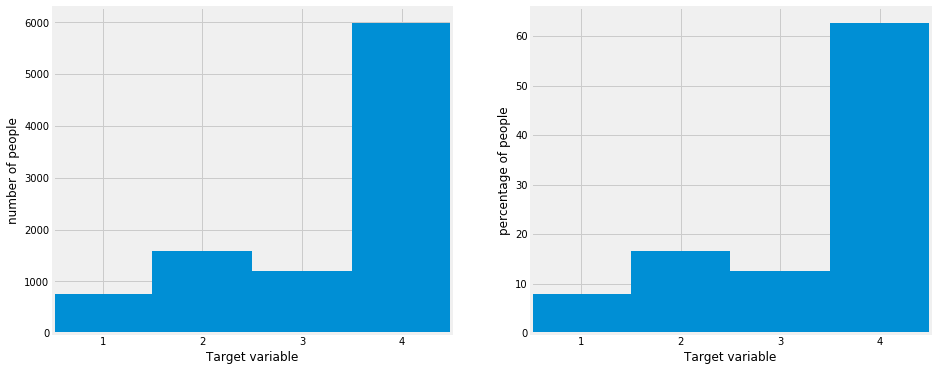

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].hist(train['Target'], bins=[0.5, 1.5, 2.5, 3.5, 4.5]);
ax[1].hist(train['Target'], bins=[0.5, 1.5, 2.5, 3.5, 4.5], normed=True);
ax[0].set_xlabel('Target variable')
ax[0].set_ylabel('number of people')
ax[0].set_xlim([0.5, 4.5])
ax[0].set_xticks(range(1, 5))
ax[0].grid(True)
ax[1].set_xlabel('Target variable')
ax[1].set_ylabel('percentage of people')
ax[1].set_yticks(np.arange(0.0, 0.7, 0.1))
ax[1].set_yticklabels(range(0, 70, 10))
ax[1].set_xlim([0.5, 4.5])
ax[1].set_xticks(range(1, 5))
ax[1].grid(True)
plt.show()

This shows the data is really skewed, so in order to overcome this we may have to oversample our data or use bootstrapping to solve this problem (later on we will just use boot strapping, however here I will show an example of oversampling). This will help our model in devlopment by giving it more "examples" of individuals who are suffering from poverty, and therefore will help us classify those people better. This is something that we need to take into account when developing a model.

## Oversampling

Lets oversample our data, for use later in our models

In [242]:
train_overs = RandomOverSampler(random_state=0)
x_resampled, y_resampled = train_overs.fit_resample(x_train, y_train)

([<matplotlib.axis.XTick at 0x1a239a0400>,
 <a list of 4 Text xticklabel objects>)

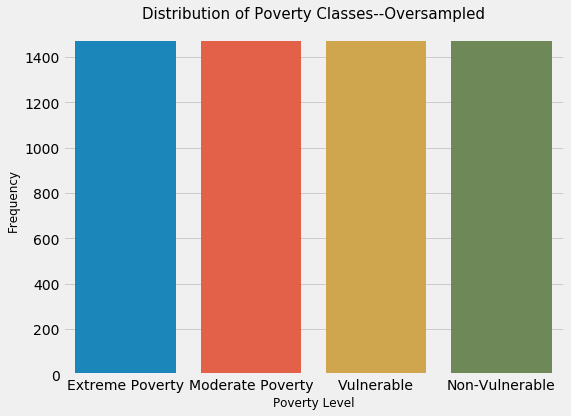

In [248]:
f, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y_resampled)
plt.title('Distribution of Poverty Classes--Oversampled', fontsize=15)
plt.xlabel('Poverty Level', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty', 'Moderate Poverty', 'Vulnerable', 'Non-Vulnerable'])

Now all the data would be equally sampled, and our models could predict better

# Visualization

Because I know we will just end up using a random forest model, visualization is not super important. However it is still useful to visualize our data. One especially useful aspect of visualization when it comes to classification is visualizing our data in terms of the different 'classes'. Below we look at a number of different variables, looking to see if we can see any general patterns between the different classes between our variables. 

/Users/zacharychild/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


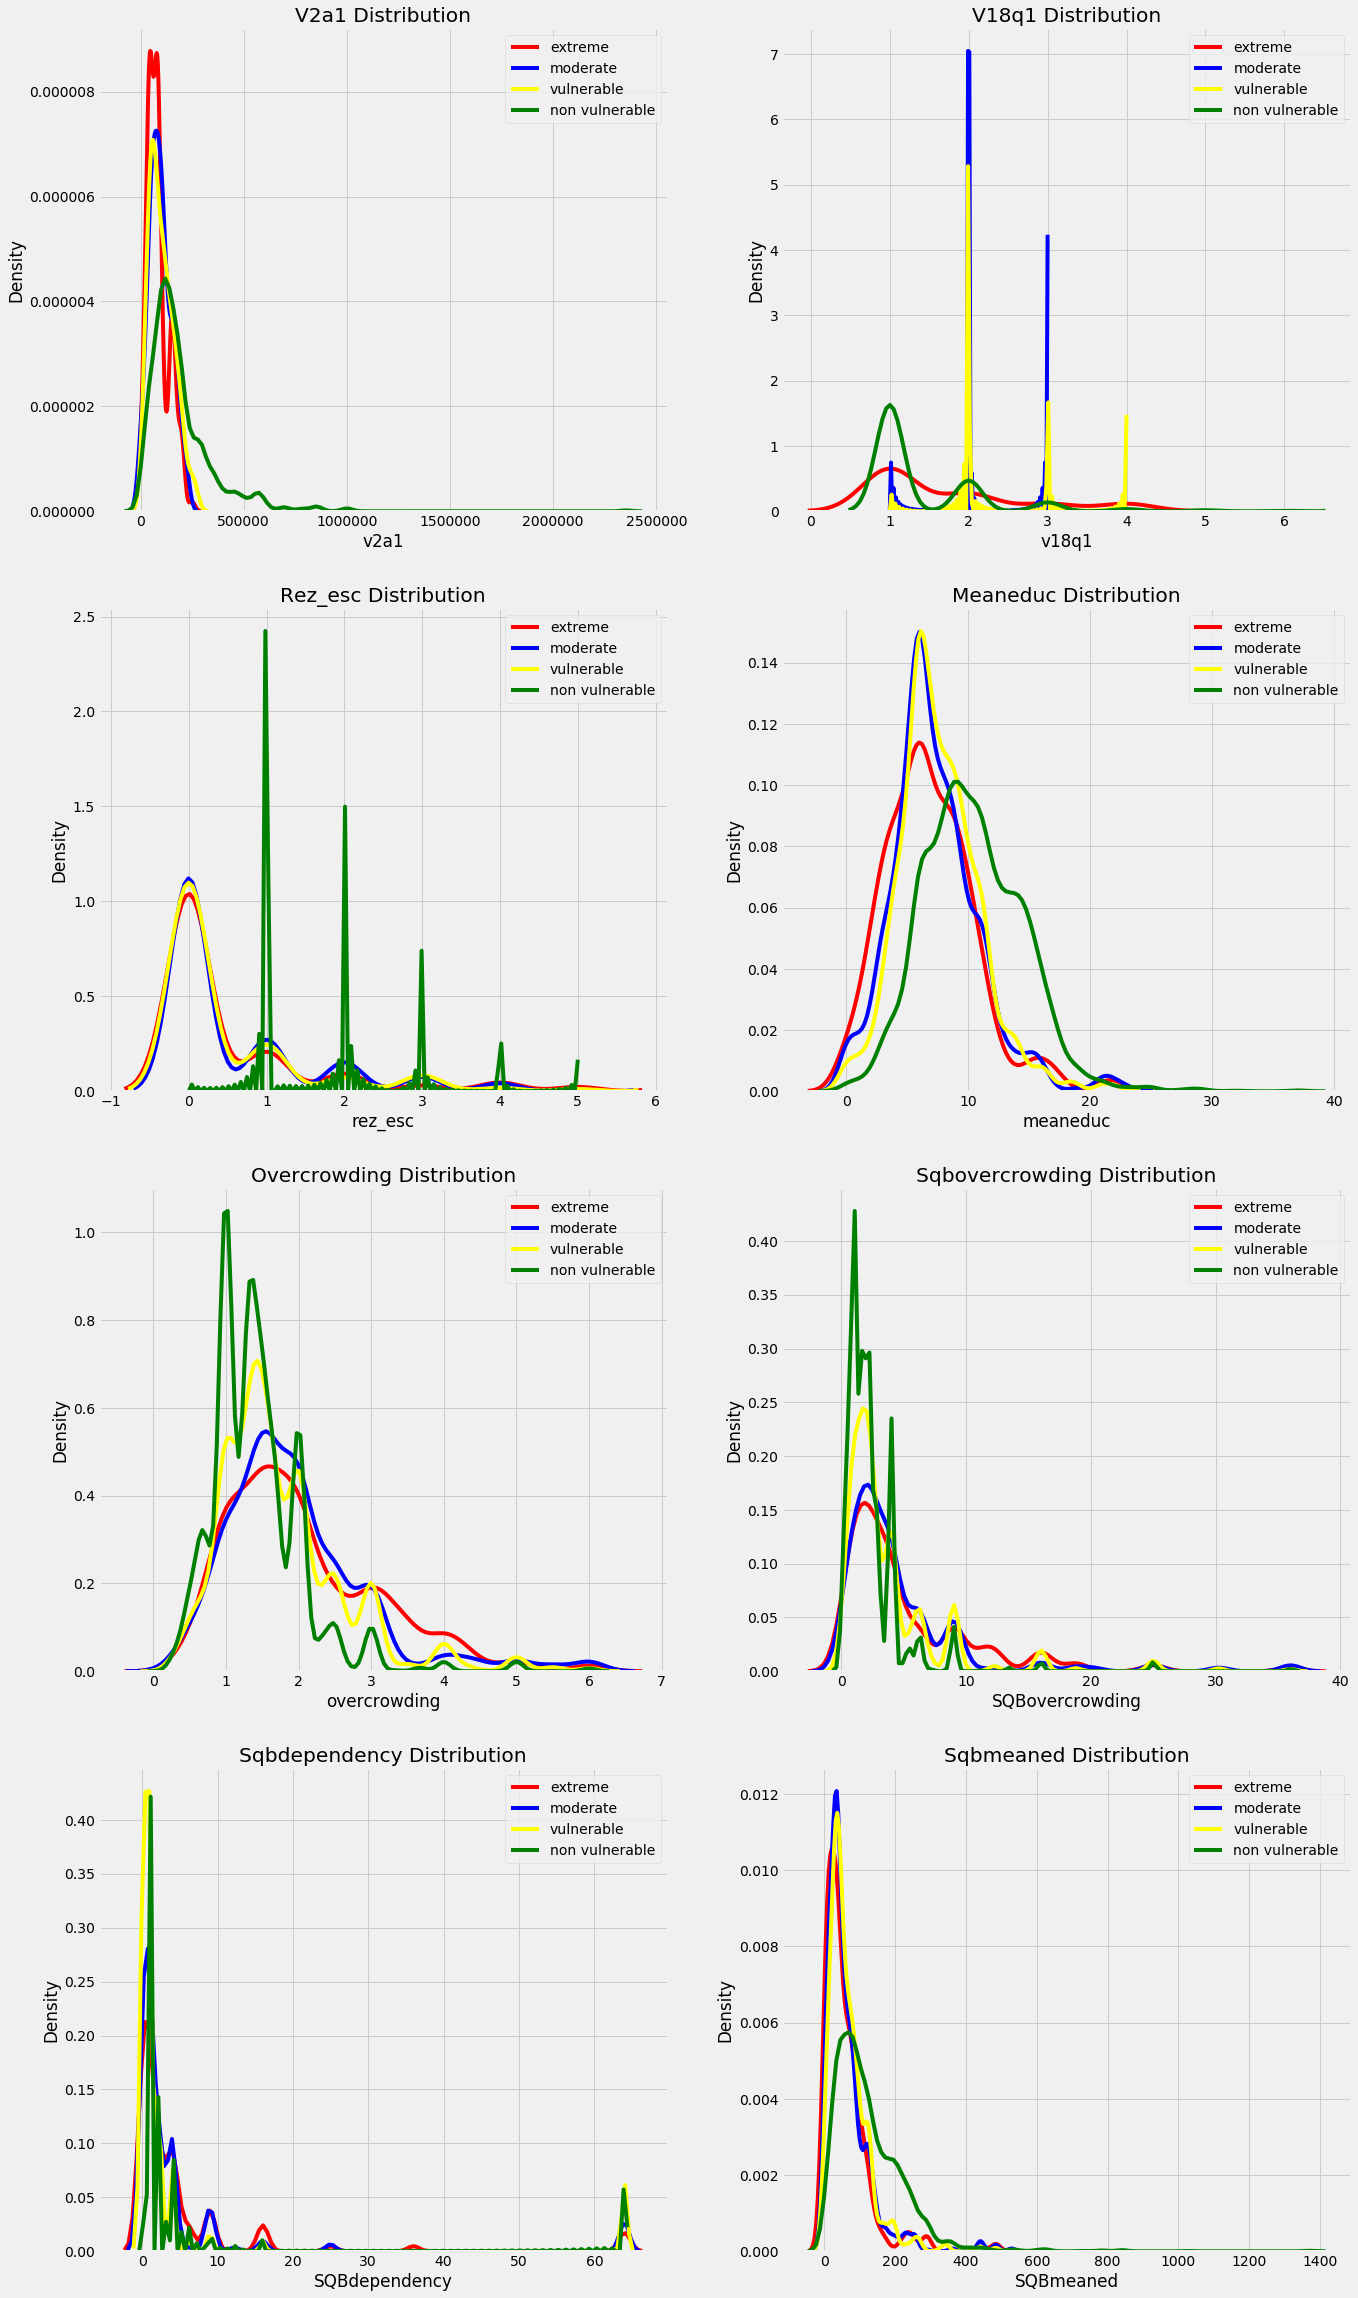

In [247]:
plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'blue', 3: 'yellow', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Looking at all these different graphs we see that some of our variables do tend to differ from class to class

In [35]:
train.groupby('Target')['v2a1'].median()

Target
1     80000.0
2     90000.0
3     90000.0
4    150000.0
Name: v2a1, dtype: float64

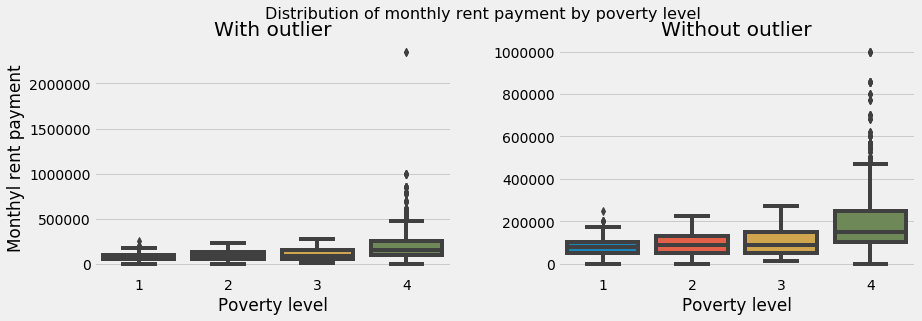

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2);
sns.boxplot(x='Target', y='v2a1', data=train, ax=ax1);
sns.boxplot(x='Target', y='v2a1', data=train[train.v2a1 < 2000000], ax=ax2);
ax1.set_title('With outlier');
ax2.set_title('Without outlier');
ax1.set_xlabel('Poverty level');
ax2.set_xlabel('Poverty level');
ax1.set_ylabel('Monthyl rent payment');
ax2.set_ylabel('');
fig.suptitle('Distribution of monthly rent payment by poverty level', x=1, y=1, fontsize=16);
fig.subplots_adjust(left=0.1, right=2, wspace=0.3);

Here we see a clear example of differences between the different classes. This variable v2a1, indicating the monthly rent payment made by an individual, shows a clear distribution difference. 

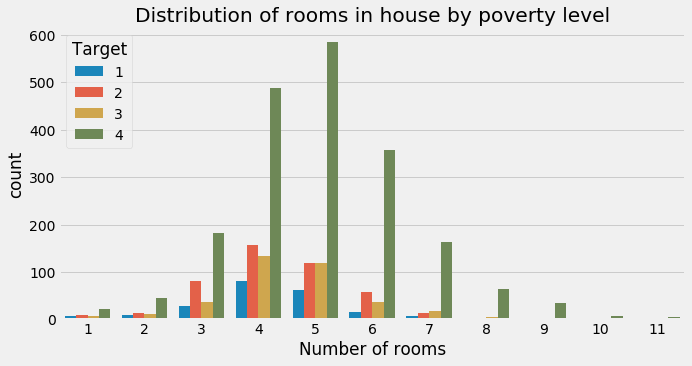

In [37]:
train_by_hhid = train.groupby('idhogar')
rm_by_id = train_by_hhid['Target', 'rooms'].first()

plt.figure(figsize=(10, 5));
sns.countplot(x='rooms', hue='Target', data=rm_by_id);
plt.title('Distribution of rooms in house by poverty level');
plt.xlabel('Number of rooms');

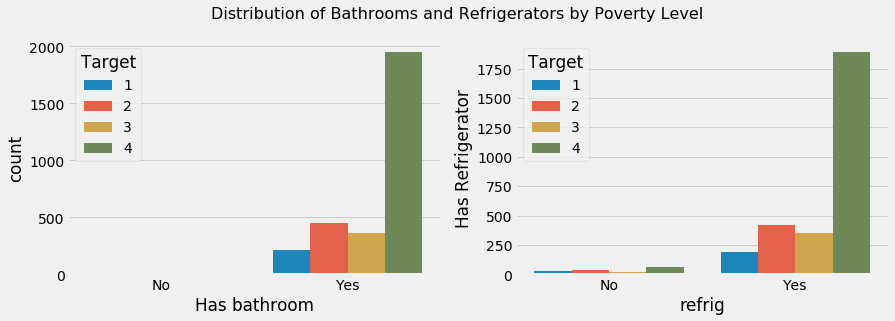

In [38]:
bathroom_by_id = train_by_hhid['Target', 'v14a', 'refrig'].first()

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x='v14a', hue='Target', data=bathroom_by_id, ax=ax1);
sns.countplot(x='refrig', hue='Target', data=bathroom_by_id, ax=ax2);
ax1.set_xticklabels(['No', 'Yes']);
ax2.set_xticklabels(['No', 'Yes']);
ax1.set_xlabel('Has bathroom');
ax2.set_ylabel('Has Refrigerator');
fig.subplots_adjust(left=0.1, right=2)
fig.suptitle('Distribution of Bathrooms and Refrigerators by Poverty Level', x=1, y=1, fontsize=16);

This variable seems to have very clear difference between the different classes! Which is a good sign that our model will be able to make some accurate predictions

/Users/zacharychild/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/zacharychild/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


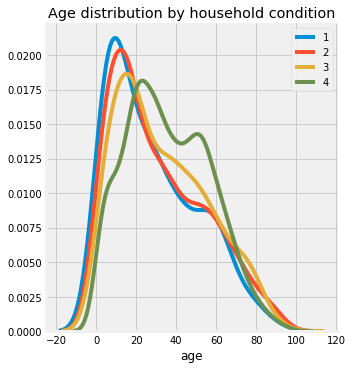

In [102]:
p = sns.FacetGrid(data = train, hue = 'Target', size = 5, legend_out=True)
p = p.map(sns.kdeplot, 'age')
plt.legend()
plt.title("Age distribution by household condition")
p;

Looking through all of these visualizations it seems there are plenty of differences between our variables when it comes to our target variable. So even though this is a complicated question--being able to predicty economic variables, I am confident that we should be able to do it using a model such as random forest. 

# Clean Data

First things first,lets clean the data so we can begin modeling! (the most important part)

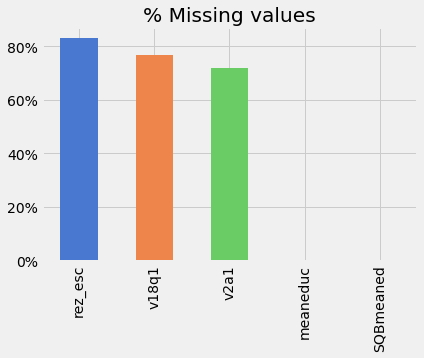

In [362]:
needclean = train.isnull().sum().sort_values(ascending=False)
needclean= (missing[missing > 0] / train.shape[0])
ax = missing.round(3).plot.bar();
ax.set_title('% Missing values')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

So it seems like we don't have that many variables with missing values! Thats good news. It seems like a few of our variables account for most of the missing values

'rez_esc' - year behind in schooling
'v18q1' - owns a tablet
'v2a1' - monthly rent payments

In [96]:
train.columns[train.dtypes==object]

Index(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], dtype='object')

In [313]:
relabel_cols = ['edjefe', 'edjefa', 'dependency']

train[relabel_cols] = train[relabel_cols].replace({'yes':1, 'no':1}).astype(float)
test[relabel_cols] = test[relabel_cols].replace({'yes':1, 'no':1}).astype(float)

Combine data sets

In [314]:
ntrain = train.shape[0]
full_df = pd.concat((train.drop('Target', axis = 1), test)).reset_index(drop = True)
full_df = full_df.drop('Id', axis = 1)

Drop unneccesary variables, and our target variable from out test set

In [315]:
full_df.isna().sum().sort_values(ascending = False)

rez_esc            27581
v18q1              25468
v2a1               24263
meaneduc              36
SQBmeaned             36
v14a                   0
sanitario6             0
techocane              0
techootro              0
cielorazo              0
abastaguadentro        0
abastaguafuera         0
abastaguano            0
public                 0
planpri                0
noelec                 0
coopele                0
sanitario1             0
sanitario2             0
sanitario3             0
sanitario5             0
energcocinar1          0
refrig                 0
energcocinar2          0
energcocinar3          0
energcocinar4          0
elimbasu1              0
elimbasu2              0
elimbasu3              0
elimbasu4              0
                   ...  
parentesco2            0
parentesco1            0
estadocivil7           0
estadocivil6           0
estadocivil4           0
instlevel2             0
estadocivil3           0
estadocivil2           0
estadocivil1           0


According to the documentation of this project the variables with missing data are defined as the following:
rez_esc - Years behind in school
v18q1 - Number of tablets in the household
v2a1 - Monthly rent payment
meaneduc - Average years of education for adults in the household
SQBmeaned - Average years of education for adults squared

In [316]:
full_df['v18q1'].head(10)

0    NaN
1    1.0
2    NaN
3    1.0
4    1.0
5    1.0
6    1.0
7    NaN
8    NaN
9    NaN
Name: v18q1, dtype: float64

In [317]:
full_df['v18q1'].value_counts()

1.0    5883
2.0    1449
3.0     447
4.0     125
5.0      31
6.0      10
Name: v18q1, dtype: int64

In [318]:
full_df.v18q1 = full_df.v18q1.fillna(0)

In [319]:
full_df['v18q1'].head(10)

0    0.0
1    1.0
2    0.0
3    1.0
4    1.0
5    1.0
6    1.0
7    0.0
8    0.0
9    0.0
Name: v18q1, dtype: float64

So 'v19q1' according to discussion in the kernels (and discussion on class tuesday) only applies to young adults, as it is a variable about missing school. So we will handle that accordingly. As well 'rez_esc' seems to have a stray 99 that we do not want influincing anything so we will deal with that as well

In [320]:
full_df.loc[((full_df['age'] >= 17) | (full_df['age'] < 7)) & (full_df['rez_esc'].isnull()), 'rez_esc'] = 0

full_df.loc[(full_df['rez_esc'] == 99)] = 0

full_df['rez_esc'].isna().sum()

5

In [321]:
train.select_dtypes('object').head()

,Id,idhogar
0,ID_279628684,21eb7fcc1
1,ID_f29eb3ddd,0e5d7a658
2,ID_68de51c94,2c7317ea8
3,ID_d671db89c,2b58d945f
4,ID_d56d6f5f5,2b58d945f


'meaneduc' and 'SQBmeaned' need to be dealt with next. For 'meaneduc' we will fill it with the median value of a similar variable 'escolari' which represent "years of schooling"

For SQBmeaned this is just the square of mean education, so we will simply use this equation to fill in the missing data

In [323]:
full_df['meaneduc'] = full_df.groupby('escolari')['meaneduc'].transform(lambda x: x.fillna(x.median()))
full_df['SQBmeaned'] = (full_df.meaneduc)**2

Missing rent is a dummy variable, so we will replace missing variables with 0. 

In [361]:
full_df['missing_rent'] = 0
full_df.loc[(full_df.v2a1.isnull()), 'missing_rent'] = 1

We will continue doing this process for the last of our variables with missing values

In [21]:
full_df.loc[(full_df.tipovivi1 == 1, 'v2a1')] = 0

full_df['v2a1'] = full_df.groupby('parentesco1')['v2a1'].transform(lambda x: x.fillna(x.median()))

In [22]:
full_df.isna().any().sum()

0

### Yeaaaa!! Now to prep for modeling

In [25]:
train_complete = full_df[:ntrain]
x = train_complete.loc[train_complete['parentesco1']==1].drop('idhogar', axis = 1)
train_complete = pd.concat([x, y], axis = 1)
test_complete = full_df[ntrain:].drop('idhogar', axis = 1)
train_complete.shape

(2973, 143)

In [208]:
y=train['Target']

Split the data

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

We need a way to test our models. Using an F1-Macro approach will give us a good indicator of the models usefulness

In [367]:
def test_clf(clf):
    score = cross_val_score(clf, x, y, scoring = 'f1_macro', cv = 5)
    print(clf.__class__.__name__,"Score =", score.mean())

# Model

We can use our test to get an estimate at the effectivness of different models

In [373]:
RandF = RandomForestClassifier()
KNN = KNeighborsClassifier()
GBM = GradientBoostingClassifier()
test_clf(RandF)
test_clf(KNN)
test_clf(GBM)

RandomForestClassifier Score = 0.33581147606862494
KNeighborsClassifier Score = 0.31088580482759853
GradientBoostingClassifier Score = 0.2746608313563573


So it looks like Tyler's insight of the random forest model may be best. Also the fact that we are using this model in classificiations also lends itself to that as well. However we will still try a variety of different models to see the differences, and to also get a sense of just how bad some of these models can be with a complicated problem such as this involving classificiation. 

In [71]:
gbm = GradientBoostingClassifier(n_estimators=100).fit(X,y)

In [79]:
print (gbm)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


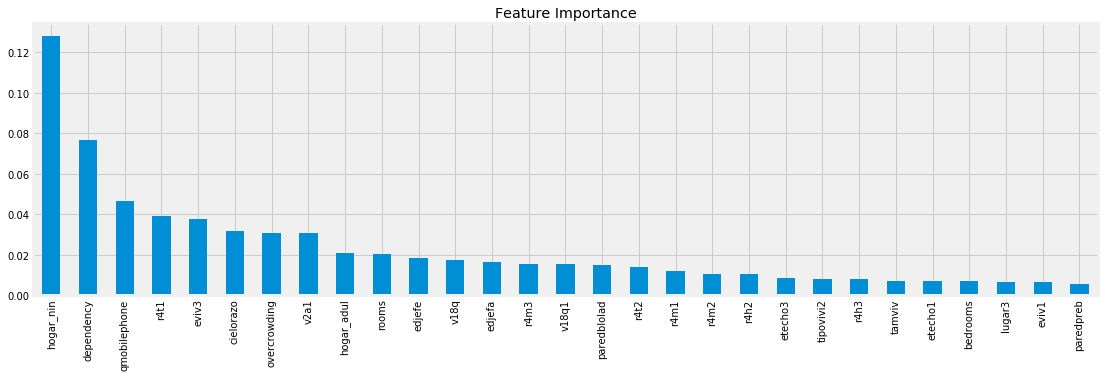

In [73]:
fi = pd.DataFrame({
    'importance':gbm.feature_importances_.round(5)
}, index=train.loc[:, keep_cols].columns)

fi.sort_values('importance', ascending=False, inplace=True)

fi.iloc[1:30, ].plot.bar(legend=None, figsize=(17,5));
plt.title('Feature Importance');

Looking at feature importance, I always am interested in how these factors compare to the correlation of each of our variables to our target variables. Getting a chart showing correlations will help us visualize this.

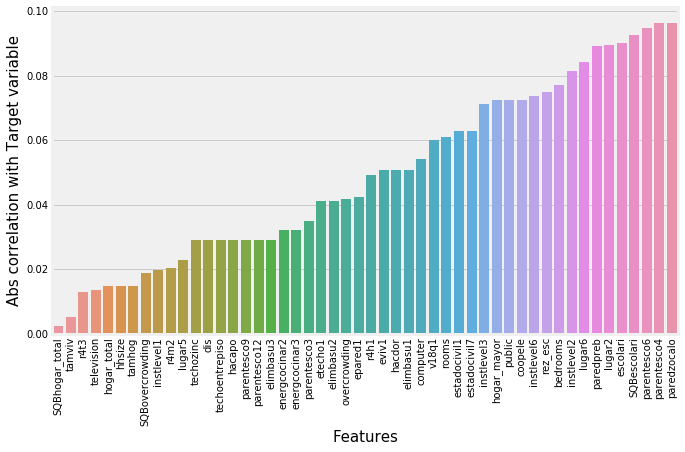

In [101]:
corrmat = train.dropna().corr().abs()['Target'].sort_values(ascending=True).drop('Target')
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=corrmat.head(50).index, y=corrmat.head(50))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Abs correlation with Target variable', fontsize=15)
plt.show()

So looking at this helps explain why in fact we use machine learning when determining our models. Correlation and feature importance are not the same thing, in fact features that are important usually are because they have higher impurity. Often we want to us variables that have high correlation, when in fact with classification models we are often looking for impurity. Especially since our target variable is a classification problem.  This is still interesting to me, and is evidence towards why we use machine learning.

## Logistic Regression

Because we need to classify, I do not have great faith in a logistic regression model in accurately predicting anything. However we will try it anyways

In [75]:
logmod = LogisticRegression(class_weight='balanced')

param_grid = { 'C': [0.5, 1] }

log_grid = GridSearchCV(logmod, cv=skf, param_grid=param_grid, scoring='f1_macro')
log_grid.fit(X, y);

/Users/zacharychild/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/zacharychild/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/zacharychild/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/zacharychild/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/zacharychild/anaconda3/lib/python3.7/si

In [76]:
print(log_grid.best_params_)
print(log_grid.best_score_)

{'C': 1}
0.35362377462891964


Better than I thought it would be. But still not highly predictive. Being this is a classification problem, so this is expected. Maybe using a logit or probit model could be better, in classifying our problem.

## XG Boost

In [210]:
xg=xgb.XGBClassifier(n_estimators=200)

In [211]:
X = X.drop(['dependency', 'edjefa', 'edjefe'],axis=1)

In [212]:
xg.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

XG Boost! It's better than logistic, however still could be improved upon. 

## Random Forest

In the end, Like Tyler, we will use a random forest model to do this classification problem

In [347]:
RandF = RandomForestClassifier(n_estimators = 300,   min_samples_split = 4,  min_samples_leaf = 4,  max_features = 20, 
 max_depth = 9, criterion = 'entropy', bootstrap = True)

In [352]:
RandF.fit(x_train, y_train)
rf_pred = RandF.predict(x_test)

In [353]:
rf_report = classification_report(y_test, rf_pred)
print(rf_report)

              precision    recall  f1-score   support

           1       0.35      0.23      0.28        52
           2       0.24      0.16      0.19       113
           3       0.11      0.03      0.05        86
           4       0.73      0.89      0.80       493

   micro avg       0.64      0.64      0.64       744
   macro avg       0.36      0.33      0.33       744
weighted avg       0.55      0.64      0.59       744



I am a big fan of the reports, as they give us all the information we need. We will change this random forest models characterisitics and see how it reacts

In [357]:
RandF = RandomForestClassifier(n_estimators = 100,   min_samples_split = 3,  min_samples_leaf = 2,  max_features = 10, 
 max_depth = 8, criterion = 'entropy', bootstrap = True)

In [358]:
RandF.fit(x_train, y_train)
rf_pred = RandF.predict(x_test)

In [359]:
rf_report = classification_report(y_test, rf_pred)
print(rf_report)

              precision    recall  f1-score   support

           1       0.64      0.13      0.22        52
           2       0.34      0.17      0.22       113
           3       1.00      0.03      0.07        86
           4       0.71      0.97      0.82       493

   micro avg       0.68      0.68      0.68       744
   macro avg       0.67      0.33      0.33       744
weighted avg       0.68      0.68      0.60       744



It seems that we can continually improve 

In [363]:
RandF = RandomForestClassifier(n_estimators = 300,   min_samples_split = 4,  min_samples_leaf = 1,  max_features = 10, 
 max_depth = 8, criterion = 'entropy', bootstrap = True)

In [364]:
RandF.fit(x_train, y_train)
rf_pred = RandF.predict(x_test)

In [365]:
rf_report = classification_report(y_test, rf_pred)
print(rf_report)

              precision    recall  f1-score   support

           1       0.50      0.12      0.19        52
           2       0.32      0.17      0.22       113
           3       1.00      0.03      0.07        86
           4       0.71      0.97      0.82       493

   micro avg       0.68      0.68      0.68       744
   macro avg       0.63      0.32      0.32       744
weighted avg       0.67      0.68      0.60       744



Lets have the computer do the work for us in determing the parameters which will optimize our random forest model

In [344]:
hparams = {'RandF' : {'n_estimators' : np.arange(100,2000,100), 'criterion' : ['gini', 'entropy'],'min_samples_split' : np.arange(2, 5, 1),
  'min_samples_leaf' : [1, 2, 4], 'max_features' : np.arange(10, 50, 10),'max_depth' : np.arange(3, 10, 1),'bootstrap': [True, False]}
         }

In [345]:
def hp_tune(clf, hparams):
    clf_rs = RandomizedSearchCV(clf, param_distributions = hparams, 
                                n_iter = 20, scoring = 'f1_macro', verbose=1)
    clf_rs.fit(x, y)
    clf_rs_pred = clf_rs.predict(x_test)
    score = f1_score(y_test, clf_rs_pred, average = 'macro')
    print('F1 Score: %s \n' %(score))
    print('Best Parameters:',clf_rs.best_params_)

In [346]:
RandF = hp_tune(RandF, hparams['RandF'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.4min finished


F1 Score: 0.5275959079283887 

Best Parameters: {'n_estimators': 900, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 8, 'criterion': 'gini', 'bootstrap': True}


Now lets use those best parameters to optimize our model!

In [ ]:
RandF = RandomForestClassifier(n_estimators = 900, 
                               min_samples_split = 4, 
                               min_samples_leaf = 2, 
                               max_features = 10, 
                               max_depth = 8, 
                               criterion = 'gini', 
                               bootstrap = True)

In [355]:
RandF.fit(x_train, y_train)
rf_pred = RandF.predict(x_test)

In [356]:
rf_report = classification_report(y_test, rf_pred)
print(rf_report)

              precision    recall  f1-score   support

           1       0.50      0.10      0.16        52
           2       0.33      0.19      0.24       113
           3       1.00      0.03      0.07        86
           4       0.72      0.97      0.82       493

   micro avg       0.68      0.68      0.68       744
   macro avg       0.64      0.32      0.32       744
weighted avg       0.68      0.68      0.60       744



We improved significantly over our original random forest model. This model is much better than a logistic model that we started with. We could go further improving this model by looking and changing weights by looking at feature importance. It seems that we are slightly overfitting. Overall I am really pleased with this model (especially since the computer generated the greatest possible set of conditions to work with. I would trust this model to make pretty general predictions. However I think it needs to be improved upon greatly before peoples lives are put at risk (not litterally at risk, though I'm sure if a family doesn't get much needed money from the government there could be great consequences) I do think this model is a great start--getting a working random forest, and begginning to look into feature importance and other factors is a great start. I tried multiple models, and I attempted to fine tune some of the models so that they would function better. Overall I am proud of my work thus far!

# Submission

In [ ]:
df_test[['Id', 'Target']].to_csv('submission.csv', index=False)

Apparently we don't have to submit, so we are good to go!